In [ ]:
%config InlineBackend.figure_format = "retina"
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from IPython.display import Math, display
from matplotlib.axes import Axes
from scipy import constants as const
from scipy.integrate import quad
from scipy.optimize import root_scalar
from tqdm import tqdm

import fewfermions.analysis.units as si
from fewfermions.simulate.traps.twod.trap import PancakeTrap
from fewfermions.style import FIGS_PATH, setup

In [2]:
colors, colors_alpha = setup()
pass

In [3]:
initial_power = 291.5 * si.uW
trap: PancakeTrap = PancakeTrap(
    power=0,  # Set pancake laser power to 0, no 2D trap
    grad_z=15 * si.G / si.cm,
    grad_r=0,
    power_tweezer=initial_power,
    waist_tweezer=1.838 * si.um,
)
axial_width = trap.get_tweezer_rayleigh()

x, y, z = trap.x, trap.y, trap.z

In [4]:
aspect_ratio = trap.get_omega_r_tweezer() / trap.get_omega_ax_tweezer()
_aspect_ratio_latex = sp.latex(trap.omega_r_tweezer / trap.omega_ax_tweezer)
display(Math(f"{_aspect_ratio_latex} \\approx {trap.subs(aspect_ratio).evalf():.2f}"))

<IPython.core.display.Math object>

In [5]:
waist = trap.subs(
    sp.solve(
        trap.get_omega_r_tweezer() / trap.get_omega_ax_tweezer() - 7,
        trap.waist_tweezer,
    )[0]
).evalf()

display(
    Math(
        f"{sp.latex(trap.waist_tweezer)}\\left({_aspect_ratio_latex} = 7\\right)"
        f" = {waist/si.um:.2f}\\mathrm{{\\mu m}}"
    )
)

<IPython.core.display.Math object>

In [28]:
n_spill_steps = 100

trap[trap.power_tweezer] = initial_power

spill_power_factor = np.linspace(0.7, 0.52, num=n_spill_steps)
powers = trap[trap.power_tweezer] * spill_power_factor
t_spill = 25 * si.ms
atom_number = np.zeros_like(powers)

# Number of energy levels to compute
# will change over time to avoid calculating too many levels
n_levels = 30
# Resolution of the potential when solving numerically
n_pot_steps = 1000

for i, power in enumerate(tqdm(powers)):
    trap[trap.power_tweezer] = power
    # Solve the hamiltonian numerically in axial direction
    energies, states, potential, coords = trap.nstationary_solution(
        trap.z, (-0.5 * axial_width, 1.8 * axial_width), n_pot_steps, k=n_levels
    )

    # Determine the potential and its derivatives
    pot_ax = trap.subs(trap.get_potential())
    pot_diff_ax = sp.diff(pot_ax, trap.z)
    pot_diff2_ax = sp.diff(pot_diff_ax, trap.z)
    pot_diff3_ax = sp.diff(pot_diff2_ax, trap.z)
    pot_diff_ax_numpy = sp.lambdify(trap.z, pot_diff_ax.subs({x: 0, y: 0}))
    pot_diff2_ax_numpy = sp.lambdify(trap.z, pot_diff2_ax.subs({x: 0, y: 0}))
    pot_diff3_ax_numpy = sp.lambdify(trap.z, pot_diff3_ax.subs({x: 0, y: 0}))

    barrier = root_scalar(
        pot_diff_ax_numpy,
        x0=1.5 * float(trap.subs(axial_width)),
        fprime=pot_diff2_ax_numpy,
        xtol=1e-28,
        fprime2=pot_diff2_ax_numpy,
    ).root
    minimum = root_scalar(
        pot_diff_ax_numpy,
        x0=0,
        fprime=pot_diff2_ax_numpy,
        xtol=1e-28,
        fprime2=pot_diff2_ax_numpy,
    ).root
    # States that are below the potential barrier
    bound_states = energies < potential(barrier)

    n_bound_states = np.sum(bound_states)
    n_levles = n_bound_states + 3  # add 3 more levels to be safe

    # Density of states is larger on the left than on the right
    # Likely that the state in question is a true bound state
    true_bound_states = np.logical_and(
        bound_states,
        np.sum(states[:, coords[z] < barrier] ** 2, axis=1)
        > np.sum(states[:, coords[z] > barrier] ** 2, axis=1),
    )

    transmission_probability = np.full_like(energies, np.nan, dtype=float)
    for j, energy in enumerate(energies):
        if not true_bound_states[j]:
            continue
        intersect_end = root_scalar(
            lambda x: potential(x) - energy,
            bracket=(barrier, 3 * float(trap.subs(axial_width))),
        ).root
        intersect_start = root_scalar(
            lambda x: potential(x) - energy,
            bracket=(minimum, barrier),
        ).root
        barrier_interval = np.logical_and(
            coords[z] > intersect_start, coords[z] < intersect_end
        )
        s = quad(
            lambda x: np.sqrt(
                2
                * float(trap.subs(trap.m))
                * np.clip(potential(x) - energy, a_min=0, a_max=None)
            )
            / const.hbar,
            intersect_start,
            intersect_end,
        )
        transmission_probability[j] = sp.exp(-2 * s[0])
    tunneling_rate = (
        transmission_probability * np.abs(energies - potential(minimum)) / const.h
    )
    atom_number[i] = 2 * np.sum(np.exp(-t_spill * tunneling_rate[true_bound_states]))

100%|██████████| 100/100 [00:26<00:00,  3.83it/s]


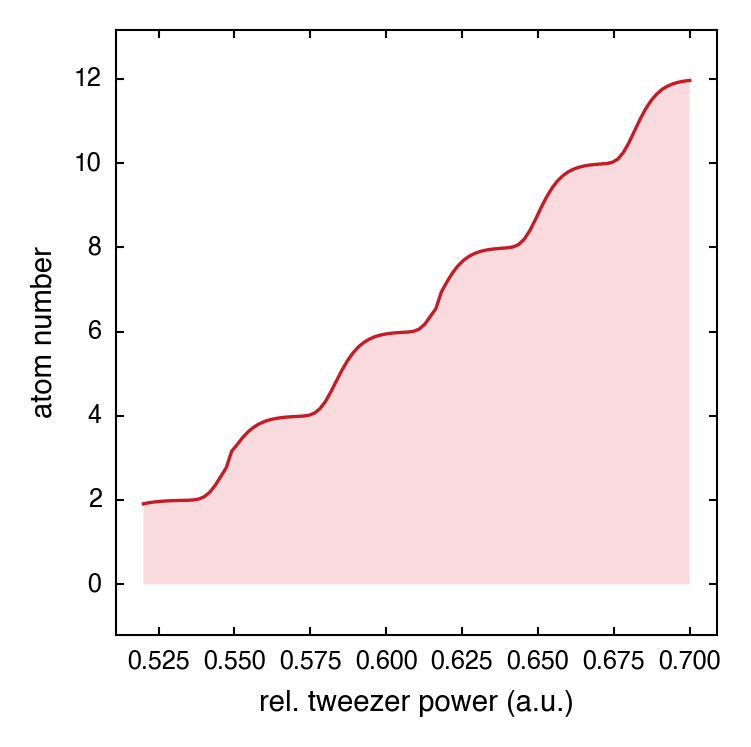

In [29]:
ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(2.5, 2.5))

ax.set_xlabel("rel. tweezer power (a.u.)")
ax.set_ylabel("atom number")
ax.plot(spill_power_factor, atom_number, marker="None")
ax.fill_between(spill_power_factor, atom_number, fc=colors_alpha["red"], alpha=0.5)
fig.savefig(FIGS_PATH / "twodtrap" / "1D Stufenplot.pdf")

In [8]:
trap[trap.power_tweezer] = 0.6 * initial_power
# Solve the hamiltonian numerically in axial direction
energies, states, potential, coords = trap.nstationary_solution(
    trap.z, (-0.5 * axial_width, 3 * axial_width), n_pot_steps, k=n_levels
)

pot_ax = trap.subs(trap.get_potential())
pot_diff_ax = sp.diff(pot_ax, trap.z)
pot_diff2_ax = sp.diff(pot_diff_ax, trap.z)
pot_diff3_ax = sp.diff(pot_diff2_ax, trap.z)
pot_diff_ax_numpy = sp.lambdify(trap.z, pot_diff_ax.subs({x: 0, y: 0}))
pot_diff2_ax_numpy = sp.lambdify(trap.z, pot_diff2_ax.subs({x: 0, y: 0}))
pot_diff3_ax_numpy = sp.lambdify(trap.z, pot_diff3_ax.subs({x: 0, y: 0}))

barrier = root_scalar(
    pot_diff_ax_numpy,
    x0=1.5 * float(trap.subs(axial_width)),
    fprime=pot_diff2_ax_numpy,
    xtol=1e-18,
    fprime2=pot_diff2_ax_numpy,
).root

# States that are below the potential barrier
bound_states = energies < potential(barrier)


# Density of states is larger on the left than on the right
# Likely that the state in question is a true bound state
true_bound_states = np.logical_and(
    bound_states,
    np.sum(states[:, coords[z] < barrier] ** 2, axis=1)
    > np.sum(states[:, coords[z] > barrier] ** 2, axis=1),
)

In [16]:
width_np = float(trap.subs(axial_width))

z_np = np.linspace(-0.5 * width_np, 2 * width_np, num=1000)

-5.719499903379515e-30


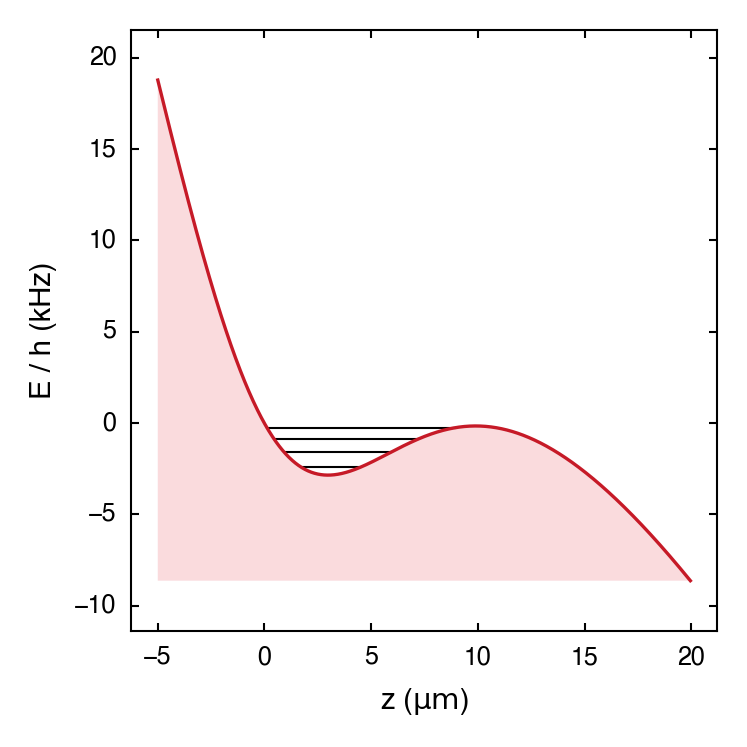

In [21]:
ax: plt.Axes
fig, ax = plt.subplots(figsize=(2.5, 2.5))
# ax.set_title("Axial")
abs_min = np.min(potential(z_np))
print(abs_min)
ax.fill_between(
    z_np / si.um,
    potential(z_np) / const.h / si.kHz,
    abs_min / const.h / si.kHz,
    fc=colors_alpha["red"],
    alpha=0.5,
)
# ax2 = ax.twinx()

for i, bound in enumerate(true_bound_states):
    if not bound:
        continue
    energy = energies[i]
    state = states[i]
    ax.plot(
        z_np / si.um,
        np.where(
            (energy > potential(z_np)) & (z_np < barrier),
            energy / const.h / si.kHz,
            np.nan,
        ),
        c="k",
        lw=0.5,
        marker="None",
    )
    # ax1.plot(coords[trap.z], state**2, marker="None", c="k")

ax.plot(z_np / si.um, potential(z_np) / const.h / si.kHz, marker="None")
ax.set_xlabel(r"z ($\mathrm{\mu m}$)")
ax.set_ylabel(r"E / h (kHz)")

fig.savefig(FIGS_PATH / "twodtrap" / "1D Spilling Example.pdf")